In [35]:
import matplotlib.pyplot as plt
import cv2
import glob, pylab, pandas as pd
import pydicom, numpy as np
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

In [46]:
df = pd.read_csv('stage_2_train_labels.csv')
df_detailed = pd.read_csv('./stage_2_detailed_class_info.csv')

In [52]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,Normal
4,00436515-870c-4b36-a041-de91049b9ab4.png,Lung Opacity


In [51]:
df_detailed['patientId'] =   df['patientId'].astype(str) + '.png' 


In [72]:
image_gen = ImageDataGenerator(rotation_range = 30,
                              width_shift_range= 0.1, 
                              height_shift_range= 0.1,
                              rescale= 1/255,
                              shear_range=0.2,
                              zoom_range= 0.2,
                              horizontal_flip= True,
                              fill_mode='nearest',
                               validation_split =0.2
                              )
                              

In [73]:
train_image_gen = image_gen.flow_from_dataframe(dataframe = df_detailed,
                             directory= './train',
                             x_col = 'patientId',
                             y_col = 'class',
                              target_size=(256,256),
                              color_mode='rgb',
                              classes= None,
                              class_mode='categorical',
                              batch_size=32,
                              shuffle=True,
                              subset = 'training'
                             )

Found 24015 validated image filenames belonging to 3 classes.


In [74]:
test_image_gen = image_gen.flow_from_dataframe(dataframe = df_detailed,
                             directory= './train',
                             x_col = 'patientId',
                             y_col = 'class',
                              target_size=(256,256),
                              color_mode='rgb',
                              classes= None,
                              class_mode='categorical',
                              batch_size=32,
                              shuffle=True,
                              subset = 'validation'
                             )

Found 6003 validated image filenames belonging to 3 classes.


In [79]:
from tensorflow import keras
from keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Conv3D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model  

In [82]:
orig_net = DenseNet121(include_top=False, weights='imagenet', input_shape=(256,256,3)) 


In [83]:
filters = GlobalAveragePooling2D()(orig_net.output) 

In [89]:
classifiers = Dense(3, activation='softmax', bias_initializer='ones')(filters)  

In [94]:
chexnet = Model(inputs=orig_net.inputs, outputs=classifiers)  


In [95]:
chexnet.compile(loss='categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [96]:
chexnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [97]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("dense121_1.h5", monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

results = chexnet.fit_generator(train_image_gen, epochs =30, 
                              steps_per_epoch=100,
                             validation_data=test_image_gen, 
                              validation_steps=12, 
                              callbacks=[checkpoint,early])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.5494 
Epoch 00001: val_accuracy improved from -inf to 0.34635, saving model to dense121_1.h5
100/100 [==============================] - 1094s 11s/step - loss: 0.9329 - accuracy: 0.5494 - val_loss: 6.4113 - val_accuracy: 0.3464
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.7901 - accuracy: 0.6216 
Epoch 00002: val_accuracy improved from 0.34635 to 0.40625, saving model to dense121_1.h5
100/100 [==============================] - 1189s 12s/step - loss: 0.7901 - accuracy: 0.6216 - val_loss: 9.5148 - val_accuracy: 0.4062
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.6371 
Epoch 00003: val_accuracy improved from 0.40625 to 0.44271, saving model to dense121_1.h5
100/100 [==============================] - 1103s 11s/step - loss: 0.7669 - accuracy: 0.6371 - val_loss: 2.1097 - val_accuracy: 0.4427
Epoch 4/30
100/100 [====================

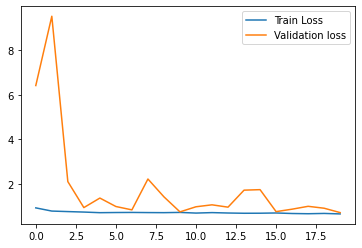

In [98]:
plt.plot(results.history["loss"], label='Train Loss')
plt.plot(results.history["val_loss"], label='Validation loss')
plt.legend();

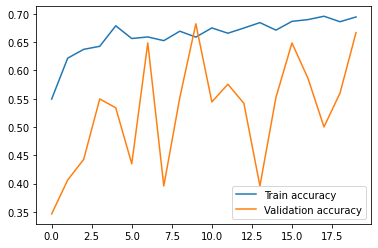

In [99]:
plt.plot(results.history["accuracy"], label='Train accuracy')
plt.plot(results.history["val_accuracy"], label='Validation accuracy')
plt.legend();